## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Loading the Dataset

In [5]:
# Read the JSON file into a list of JSON objects with the specified encoding
with open("yelp_academic_dataset_review.json", "r", encoding="utf-8") as json_file:
    data = [json.loads(line) for line in json_file]

# Create a DataFrame from the list of JSON objects
df = pd.DataFrame(data)

In [3]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


## Exploratory Data Analysis

In [7]:
df.shape

(6685900, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685900 entries, 0 to 6685899
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 459.1+ MB


In [6]:
df.describe()

,stars,useful,funny,cool
count,6.685900e+06,6.685900e+06,6.685900e+06,6.685900e+06
mean,3.716199e+00,1.354134e+00,4.827667e-01,5.787708e-01
std,1.463643e+00,3.700192e+00,2.378646e+00,2.359024e+00
min,1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00
max,5.000000e+00,1.241000e+03,1.290000e+03,5.060000e+02


In [10]:
# Get the number of unique users and unique businesses
num_users = df["user_id"].nunique()
num_businesses = df["business_id"].nunique()

print(f"Number of unique users: {num_users}")
print(f"Number of unique businesses: {num_businesses}")

Number of unique users: 1987929
Number of unique businesses: 150346


### Looking at the distribution of the Star ratings given by the customers for the businesses

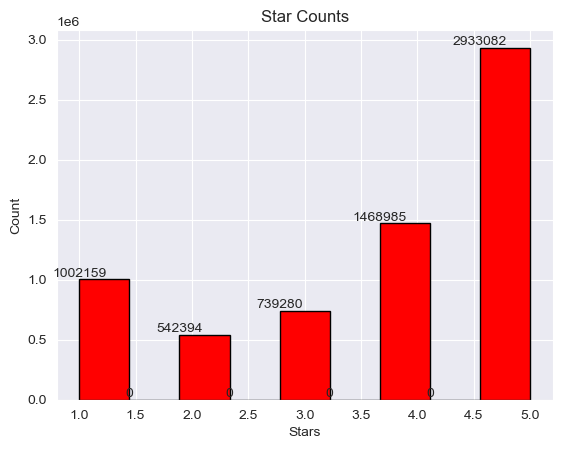

In [49]:
# Create a histogram (bar plot) with matplotlib
hist, bins, _ = plt.hist(df['stars'], bins=9, color='red', edgecolor='black')

# Add labels and title
plt.title("Star Counts")
plt.xlabel("Stars")
plt.ylabel("Count")

# Annotate the bars with counts
for i in range(len(hist)):
    plt.annotate(str(int(hist[i])), (bins[i], hist[i]), ha='center', va='bottom')

# Show the plot
plt.show()


According to the results generated, we can see that there are high number of reviews that has the highest star ratings left by the users and also a significant amount of low star ratings that has been left by the users.

### Finding the Top 20 Users by the review count left by the users

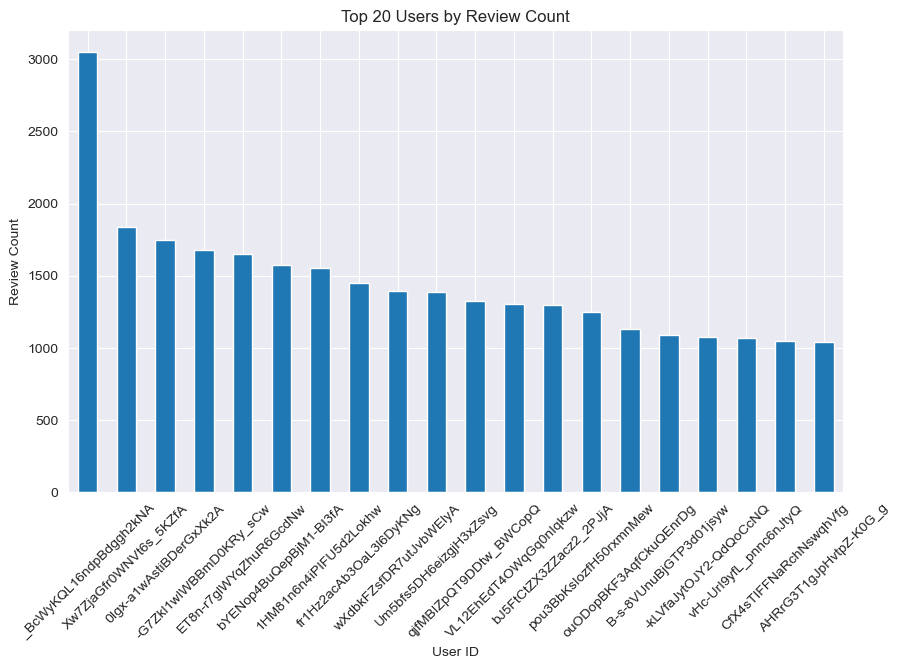

In [12]:
#Calculates the number of reviews made by each user in the dataset.
user_review_counts = df["user_id"].value_counts()

# Create a bar chart to visualize the user review counts
plt.figure(figsize=(10, 6))
user_review_counts[:20].plot(kind='bar')
plt.xlabel("User ID")
plt.ylabel("Review Count")
plt.title("Top 20 Users by Review Count")
plt.xticks(rotation=45)
plt.show()

### Finding the Top 50 Businesses according to the Average star rating

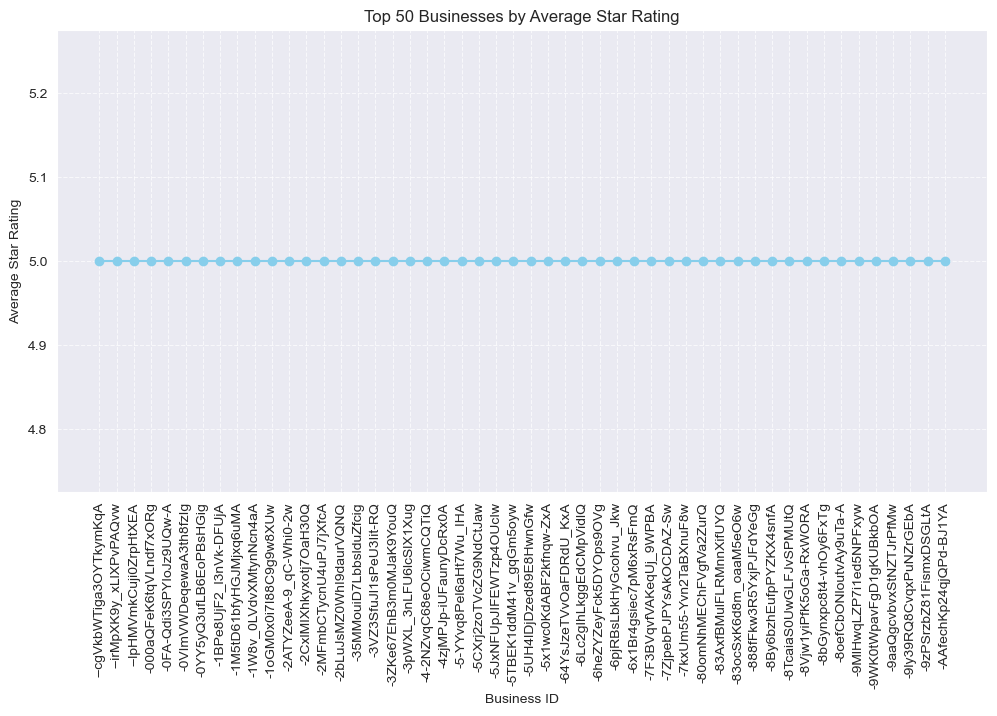

In [45]:
#Computes the average star rating given to each unique business in the dataset
average_ratings = df.groupby("business_id")["stars"].mean()

# Get the top 50 businesses by average star rating
top_50_businesses = average_ratings.nlargest(50)

# Create a line graph to visualize the average star ratings for the top 200 businesses
plt.figure(figsize=(12, 6))
plt.plot(top_50_businesses.index, top_50_businesses.values, marker='o', color='skyblue', linestyle='-')
plt.xlabel("Business ID")
plt.ylabel("Average Star Rating")
plt.title("Top 50 Businesses by Average Star Rating")

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines for reference

plt.show()

According to the result, we can see that since this dataset is quite large, after calculating the average star ratings received by all the businesses from the users, there are quite a few businesses that has received the highest average star rating; a 5.0

### Findings on the Businesses and their star Ratings

In [14]:
# Calculate the number of businesses with each average star rating
num_5_stars = (average_ratings == 5).sum()
num_4_stars = (average_ratings == 4).sum()
num_3_stars = (average_ratings == 3).sum()
num_2_stars = (average_ratings == 2).sum()
num_1_star = (average_ratings == 1).sum()

# Print the counts
print(f"Number of businesses with an average rating of 5: {num_5_stars}")
print(f"Number of businesses with an average rating of 4: {num_4_stars}")
print(f"Number of businesses with an average rating of 3: {num_3_stars}")
print(f"Number of businesses with an average rating of 2: {num_2_stars}")
print(f"Number of businesses with an average rating of 1: {num_1_star}")

Number of businesses with an average rating of 5: 8995
Number of businesses with an average rating of 4: 3885
Number of businesses with an average rating of 3: 2794
Number of businesses with an average rating of 2: 1606
Number of businesses with an average rating of 1: 1165


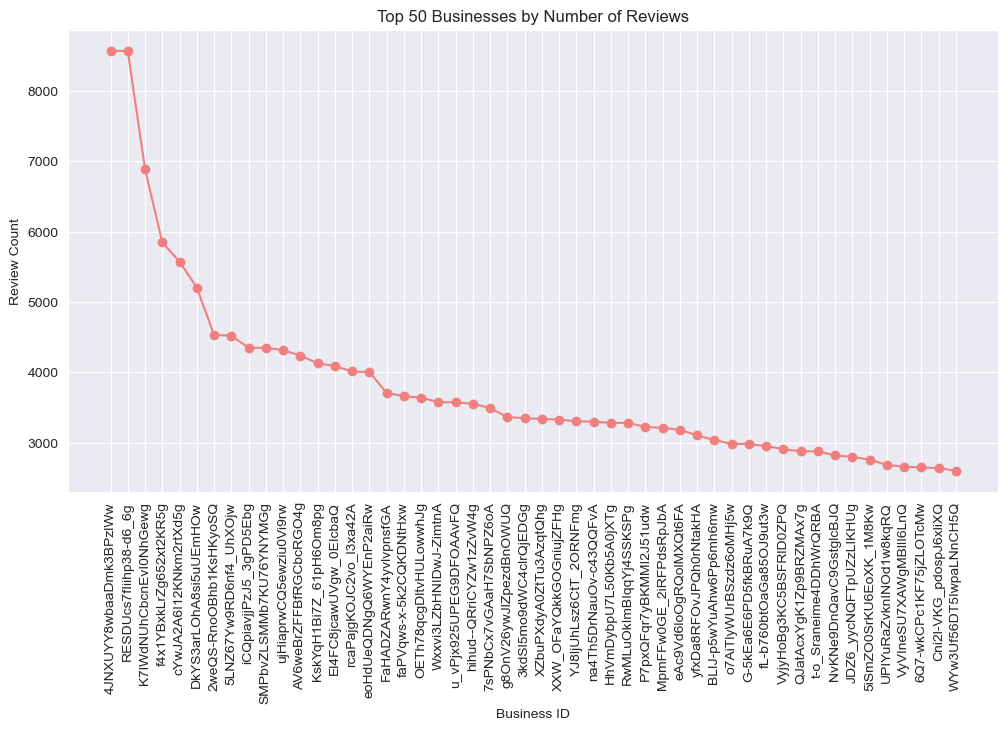

In [50]:
#Providing the number of reviews for each business
review_counts_per_business = df["business_id"].value_counts()

# Get the top 50 businesses by the number of reviews
top_50_businesses = review_counts_per_business.nlargest(50)

# Create a line chart to visualize the number of reviews for the top 50 businesses
plt.figure(figsize=(12, 6))
plt.plot(top_50_businesses.index, top_50_businesses.values, marker='o', color='lightcoral', linestyle='-')
plt.xlabel("Business ID")
plt.ylabel("Review Count")
plt.title("Top 50 Businesses by Number of Reviews")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

### Time Analysis of the Yelp Reviews

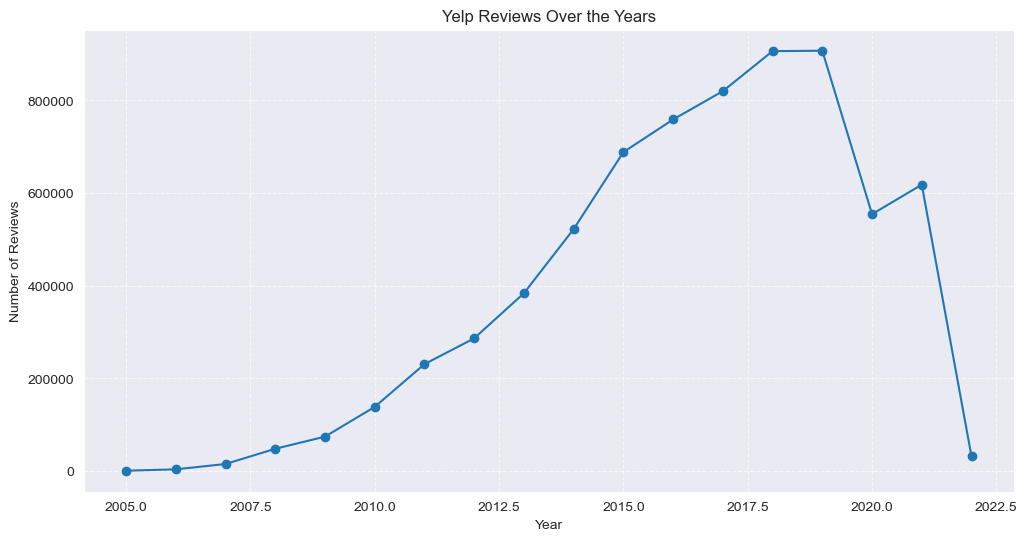

In [16]:
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the 'date' column
df['year'] = df['date'].dt.year

# Group by year and count the number of reviews per year
reviews_per_year = df.groupby(df['year']).size()

# Create a time series plot for the number of reviews per year
plt.figure(figsize=(12, 6))
plt.plot(reviews_per_year.index, reviews_per_year.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Yelp Reviews Over the Years')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Correlation between the Review Types left by the users

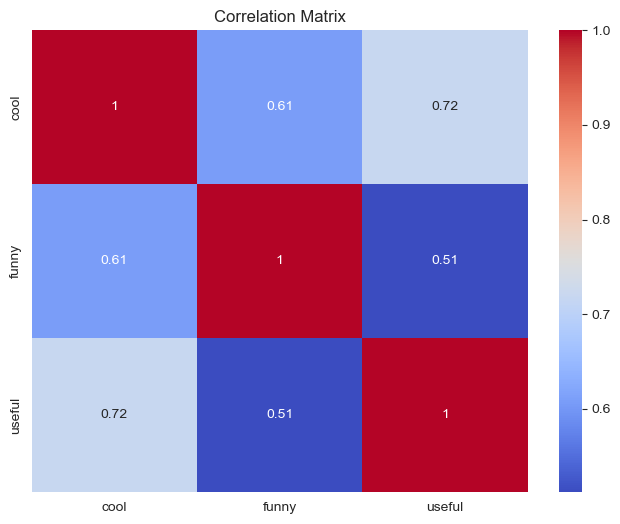

In [17]:
# Calculate and visualize the correlations between 'cool', 'funny', and 'useful'
correlation_matrix = df[['cool', 'funny', 'useful']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


According to the findings of the above code, we can see that
    - Reviews that was considered as a 'useful' review has a very high possibility of being a 'cool' review as well according to the other users
    - Reviews that was considered as a 'funny' review also has a good possibility pf being categorized as a 'cool' review according to the other users

### Displaying Top Reviewers with high ratings

In [18]:
# Identify top users with the most 'cool' ratings
top_cool_reviewers = df.groupby('user_id')['cool'].sum().nlargest(10)

# Display the top reviewers
print("Top Users with the Most 'Cool' Ratings:")
print(top_cool_reviewers)


Top Users with the Most 'Cool' Ratings:
user_id
-G7Zkl1wIWBBmD0KRy_sCw    26749
A4bsa7ykYRVCnb4h2vZALw    16997
lMY8NBPyzlPbbu-KBYfD9A    16175
tsMF0FcFcHZ8i28WzWtQXw    13780
fr1Hz2acAb3OaL3l6DyKNg    13145
vHc-UrI9yfL_pnnc6nJtyQ    12821
ET8n-r7glWYqZhuR6GcdNw    12585
wzUFZ3DaU7k9R2S54IMPfg    12124
6jjHo9Lilv3kTy87pm2ycw    10231
3QnoTcrxuafMCoTzW_AH7A     9658
Name: cool, dtype: int64


In [19]:
# Identify top users with the most 'funny' ratings
top_funny_reviewers = df.groupby('user_id')['funny'].sum().nlargest(10)

# Display the top reviewers
print("Top Users with the Most 'Funny' Ratings:")
print(top_funny_reviewers)


Top Users with the Most 'Funny' Ratings:
user_id
-G7Zkl1wIWBBmD0KRy_sCw    17774
A4bsa7ykYRVCnb4h2vZALw    11552
lMY8NBPyzlPbbu-KBYfD9A    10242
tsMF0FcFcHZ8i28WzWtQXw     8351
Kj-u8Yq1d3mLKitWsDAxpg     6827
qcf3A5mtPntTmmSfADo6tg     6759
3QnoTcrxuafMCoTzW_AH7A     5803
ET8n-r7glWYqZhuR6GcdNw     5631
wzUFZ3DaU7k9R2S54IMPfg     5581
JjXuiru1_ONzDkYVrHN0aw     5320
Name: funny, dtype: int64


In [20]:
# Identify top users with the most 'useful' ratings
top_useful_reviewers = df.groupby('user_id')['useful'].sum().nlargest(10)

# Display the top reviewers
print("Top Users with the Most 'Useful' Ratings:")
print(top_useful_reviewers)


Top Users with the Most 'Useful' Ratings:
user_id
-G7Zkl1wIWBBmD0KRy_sCw    34694
ET8n-r7glWYqZhuR6GcdNw    19474
vHc-UrI9yfL_pnnc6nJtyQ    17851
A4bsa7ykYRVCnb4h2vZALw    17702
lMY8NBPyzlPbbu-KBYfD9A    17358
fr1Hz2acAb3OaL3l6DyKNg    15356
tsMF0FcFcHZ8i28WzWtQXw    15112
wzUFZ3DaU7k9R2S54IMPfg    13400
Xw7ZjaGfr0WNVt6s_5KZfA    12011
bYENop4BuQepBjM1-BI3fA    11680
Name: useful, dtype: int64


### Top 'Useful' Reviews

In [21]:
top_N = 10  # Top 10 'useful' reviews

# Sort the dataset by the "useful" column in descending order
top_useful_reviews = df.sort_values(by='useful', ascending=False).head(top_N)

# Display the top N reviews and their associated text
print("Top {} Reviews with the Most 'Useful' Counts:".format(top_N))
for index, row in top_useful_reviews.iterrows():
    print("Review ID: ", row['review_id'])
    print("Useful Count: ", row['useful'])
    print("Review Text: ", row['text'])
    print("\n")


Top 10 Reviews with the Most 'Useful' Counts:
Review ID:  b0HBLNn02tkpC9rIyPRc_Q
Useful Count:  1182
Review Text:  Avoid at ALL costs.  Do NOT do business with Ditech.  Do not seek loan originations. Do not expect good customer service.  If your mortgage is sold to Ditech, that is a really good indication it is time to refi and get away from them.

Ditech doesn't offer decent customer support at all.  Their accounting for money you send them is deplorable.  They can't tell you from day to day what your actual balance is.  Their reps are rude, unfriendly, unhelpful, and way overpaid.  

I cannot express adequately the level of dissatisfaction I have with Ditech.  I am not being foreclosed on.  I am not late on my payments.  However, they have mismanaged my payments and my accounts and have made getting it all straightened out a nightmare.

You rarely have to deal with loan servicing companies.  It's something you should never really have to think about.  However, when there is a mess, D

### For More Deep Analysis - Creating Features

Here, we created the "Customer Experience" column, where we categorise the Stars provided to various businesses as GOOD, BAD, or NEUTRAL.

In addition, we created a new feature called "Text Length", which shows the length of the reviews. This functionality will help us understand consumer behaviour and experiences.

In [51]:
# Create a function to categorize star ratings
def categorize_customer_exp(rating):
    if rating in (1, 2):
        return 'BAD'
    elif rating == 3:
        return 'NEUTRAL'
    else:
        return 'GOOD'

# Apply the function to create the 'Customer EXP' column
df['Customer EXP'] = df['stars'].apply(categorize_customer_exp)

# Count the values in the 'Customer EXP' column
customer_exp_counts = df['Customer EXP'].value_counts()

# Calculate text length and create the 'Text length' column
df['Text length'] = df['text'].apply(lambda x: len(x.split()))

# Display the first few rows of the DataFrame
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year,Customer EXP,Text length
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36,2013,BAD,39
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33,2017,GOOD,274
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03,2016,GOOD,109
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38,2018,GOOD,68
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38,2018,BAD,673


### Customer Experience vs Text Length of the Reviews

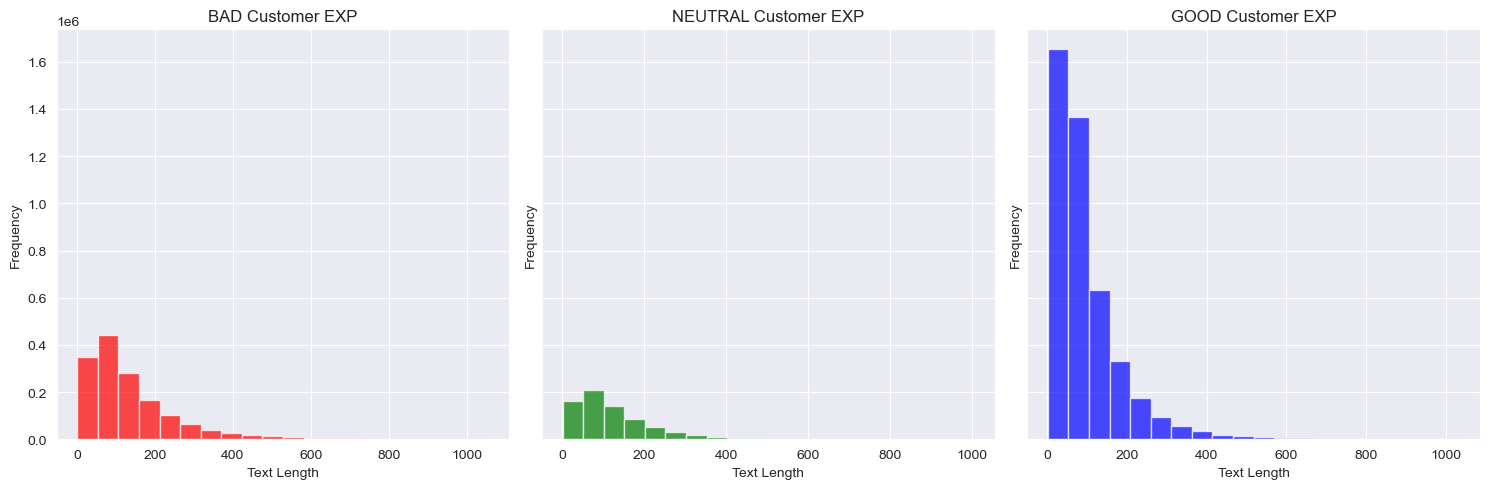

Mean Text Length by Customer EXP:
Customer EXP
BAD        142.849001
GOOD        97.205362
NEUTRAL    131.880279
Name: Text length, dtype: float64


In [52]:
# Create separate data frames for each "Customer EXP" category
bad_reviews = df[df['Customer EXP'] == 'BAD']
neutral_reviews = df[df['Customer EXP'] == 'NEUTRAL']
good_reviews = df[df['Customer EXP'] == 'GOOD']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

# Plot histograms for text length in each "Customer EXP" category
for i, (category, color) in enumerate(zip(['BAD', 'NEUTRAL', 'GOOD'], ['red', 'green', 'blue'])):
    ax = axes[i]
    ax.hist(df[df['Customer EXP'] == category]['Text length'], bins=20, color=color, alpha=0.7)
    ax.set_title(f'{category} Customer EXP')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate and display the mean text length for each "Customer EXP" category
mean_text_length = df.groupby('Customer EXP')['Text length'].mean()
print("Mean Text Length by Customer EXP:")
print(mean_text_length)


The density distributions and histograms of text lengths for reviews designated as GOOD, BAD, and NEUTRAL are shown in the graph above. People who rate a business as BAD or NEUTRAL have roughly 150 words in their evaluations, but people who are supposed to assess the business as GOOD have approximately 100 words in their reviews.


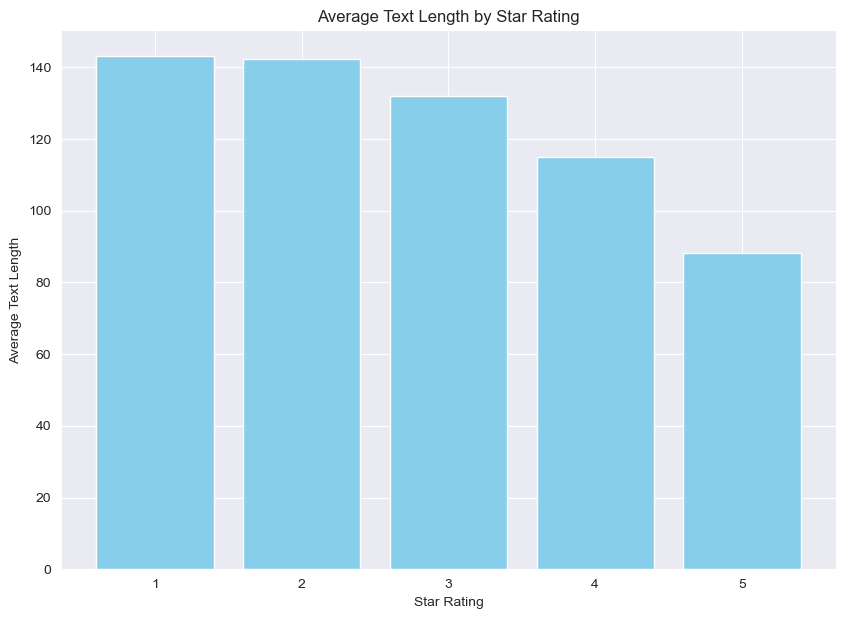

In [55]:
# Calculate the average text length for each star rating
average_text_length = df.groupby('stars')['Text length'].mean()

# Create a bar chart
plt.figure(figsize=(10, 7))
plt.bar(average_text_length.index, average_text_length.values, color='skyblue')
plt.xlabel('Star Rating')
plt.ylabel('Average Text Length')
plt.title('Average Text Length by Star Rating')
plt.xticks(average_text_length.index)
plt.show()


According to the above graph as well, we can see that customers who have given a high star rating has a low average text length(80-100) in their reviews while customers who have given a low and neutral star rating has a high average text length(120-130) in their reviews.

### Distribution of Customer Experience

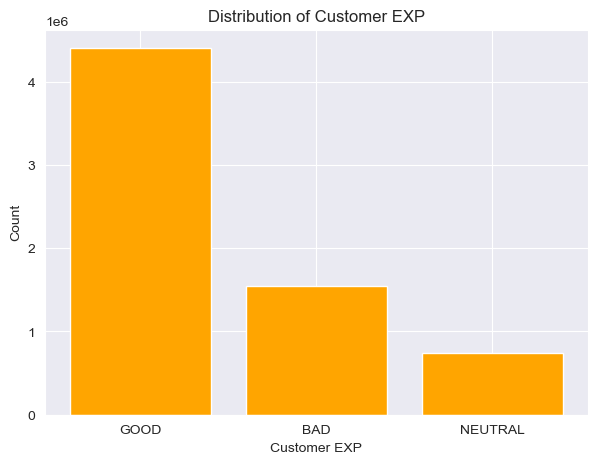

In [56]:
# Count the number of reviews in each "Customer EXP" category
customer_exp_counts = df['Customer EXP'].value_counts()

# Create a countplot using matplotlib
plt.figure(figsize=(7, 5))
plt.bar(customer_exp_counts.index, customer_exp_counts.values, color='orange')
plt.xlabel('Customer EXP')
plt.ylabel('Count')
plt.title('Distribution of Customer EXP')
plt.show()


In the bar chart depicting the distribution of customer experiences, we observe that there is a substantial number of reviews categorized as 'GOOD,' indicating a positive customer experience. Conversely, there are relatively few reviews categorized as 'NEUTRAL,' but a significant amount of 'BAD' reviews more than the 'NEUTRAL' reviews. This suggests that the majority of reviews in the dataset reflect positive customer experiences, with a smaller portion expressing neutral or negative sentiments.

### Correlation between the Review Types left by the users after adding the Text Length

In [53]:
#When we categorise the data set by STARS, we can find the correlation between COOL, USEFUL, FUNNY, and TEXT_LENGTH characteristics after adding the TEXT_LENGTH feature

# Select the columns of interest for correlation
columns_of_interest = ['stars', 'cool', 'funny', 'useful', 'Text length']

# Calculate the correlation between the selected columns by 'Customer EXP'
correlation_matrix = df.groupby('Customer EXP')[columns_of_interest].mean().corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                stars      cool     funny    useful  Text length
stars        1.000000  0.850500 -0.888077 -0.972498    -0.958732
cool         0.850500  1.000000 -0.513522 -0.949615    -0.665861
funny       -0.888077 -0.513522  1.000000  0.756585     0.982124
useful      -0.972498 -0.949615  0.756585  1.000000     0.866145
Text length -0.958732 -0.665861  0.982124  0.866145     1.000000


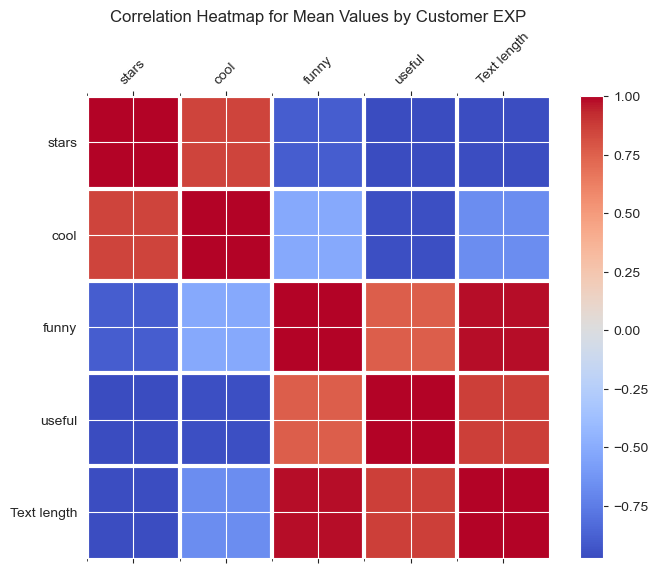

In [57]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the heatmap
cax = ax.matshow(correlation_matrix, cmap='coolwarm')
fig.colorbar(cax)

# Customize the heatmap
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(np.arange(len(correlation_matrix.index)), correlation_matrix.index)
ax.set_xticks(np.arange(-0.5, len(correlation_matrix.columns)-0.5, 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(correlation_matrix.index)-0.5, 1), minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
plt.title('Correlation Heatmap for Mean Values by Customer EXP')
plt.show()

In our analysis of the dataset, we observed notable correlations among various characteristics when categorizing by star ratings. Specifically, we found:

1. There is a strong positive correlation between the 'funny' and 'Text length' characteristics. This suggests that, in general, longer reviews tend to contain more humor or amusing content.

2. We also identified a high positive correlation between 'cool' and 'funny.' It appears that reviews with a higher number of 'funny' interactions are often considered 'cool' by other users.

3. Additionally, we noted a significant positive correlation between 'cool' and 'Text length.' Longer reviews are often associated with a higher number of 'cool' interactions.

## Preprocessing of the Dataset ('text' column cleaning)

In [4]:
# Creating a new df with the required columns
columns_required = ['review_id','stars','text']
df_rc = df[columns_required ]
df_rc.head()

,review_id,stars,text
0,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...
1,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...
2,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...
3,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...
4,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...


In [5]:
# Checking duplicate reviews
duplicates = df_rc.duplicated()

if duplicates.any():
    print("There are duplicate rows in the Data Frame.")
else:
    print("No duplicate rows found in the Data Frame.")


No duplicate rows found in the Data Frame.


In [6]:
# Checking null values
print('Number of missing values: ', df_rc.isnull().values.sum())
print('Data length: ', len(df_rc))

Number of missing values:  0
Data length:  100


### Analysing what the texts contain before preprocessing to identify what are the preprocessing techniques to be followed for the dataset

In [11]:
df_rc.text[0]

'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.'

In [12]:
df_rc.text[1000]

"My boyfriend and I were really looking forward to a couple's massage on our vegas trip this memorial day weekend. I researched a lot of spas and reviews before choosing Episage, and I'm so glad I made the right decision. First of all, I called 5 different times to see if I could reschedule our appointment since our flight and times wouldn't allow us to make our original one. Each time they tried to find a new opening for us, and even a few hours before we went they scheduled us on a Sunday after I called. Nikki and Limmie were our therapists. They went above and beyond expectations for a massage!! They set the music to that that would fit my bf and I perfectly. They taught us (mistly my bf) all about tight and knotted fascia and stretching. Limmie went through a number of stretches and flexibility therapies on me. They had us laughing and having a good time the entire session, and we got educated without even realizing we were getting educated. My boyfriend is making sure he's stretch

In [7]:
#index resetting
df_rc.reset_index(drop=True, inplace=True)
df_rc.loc[:, "index"] = df_rc.index.values
df_rc.head()

C:\Users\Lakshani_140492\AppData\Local\Temp\1\ipykernel_3824\1815367156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rc.loc[:, "index"] = df_rc.index.values


,review_id,stars,text,index
0,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,0
1,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,1
2,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,2
3,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,3
4,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,4


In [8]:
#Removing 3 stars since they can have both negative and positive feelings
df_rc = df_rc[(df_rc["stars"]!=3)]

In [9]:
df_rc.head()

,review_id,stars,text,index
0,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,0
1,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,1
2,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,2
3,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,3
4,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,4


In [10]:
#Coverting to lowercase
df_rc.loc[:, 'clean_text'] = df_rc['text'].str.lower()

In [11]:
df_rc.head()

,review_id,stars,text,index,clean_text
0,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,0,total bill for this horrible service? over $8g...
1,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,1,i *adore* travis at the hard rock's new kelly ...
2,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,2,i have to say that this office really has it t...
3,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,3,went in for a lunch. steak sandwich was delici...
4,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,4,today was my second out of three sessions i ha...


In [12]:
# removing email addresses since they do not mean anything for sentiment analysis
df_rc['clean_text'] = df_rc['clean_text'].apply(lambda x: re.sub(r'\S+@\S+', '', x))

In [13]:
df_rc.head()

,review_id,stars,text,index,clean_text
0,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,0,total bill for this horrible service? over $8g...
1,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,1,i *adore* travis at the hard rock's new kelly ...
2,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,2,i have to say that this office really has it t...
3,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,3,went in for a lunch. steak sandwich was delici...
4,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,4,today was my second out of three sessions i ha...


In [20]:
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lakshani_140492\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [15]:
# removing stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

df_rc['clean_text'] = df_rc['clean_text'].apply(lambda x: remove_stopwords(x))

In [16]:
df_rc.head()

,review_id,stars,text,index,clean_text
0,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,0,total bill horrible service? $8gs. crooks actu...
1,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,1,*adore* travis hard rock's new kelly cardenas ...
2,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,2,"say office really together, organized friendly..."
3,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,3,"went lunch. steak sandwich delicious, caesar s..."
4,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,4,today second three sessions paid for. although...


In [17]:
# Removing punctuation marks
def remove_punctuations(text):
    punctuations = string.punctuation
    return text.translate(str.maketrans('', '', punctuations))

df_rc['clean_text'] = df_rc['clean_text'].apply(lambda x: remove_punctuations(x))

In [18]:
df_rc.head()

,review_id,stars,text,index,clean_text
0,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,0,total bill horrible service 8gs crooks actuall...
1,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,1,adore travis hard rocks new kelly cardenas sal...
2,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,2,say office really together organized friendly ...
3,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,3,went lunch steak sandwich delicious caesar sal...
4,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,4,today second three sessions paid for although ...


In [19]:
# Removing special characters and emojis
def removing_special_characters(text):
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text
df_rc['clean_text'] = df_rc['clean_text'].apply(lambda x: removing_special_characters(x))

In [20]:
df_rc.head()

,review_id,stars,text,index,clean_text
0,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,0,total bill horrible service 8gs crooks actuall...
1,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,1,adore travis hard rocks new kelly cardenas sal...
2,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,2,say office really together organized friendly ...
3,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,3,went lunch steak sandwich delicious caesar sal...
4,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,4,today second three sessions paid for although ...


In [21]:
# Removing numeric characters
def remove_words_with_numerical_characters(text):
    if text and not pd.isna(text):
        words = text.split()
        filtered_words = [w for w in words if not re.findall(r'\d+', w)]
        return ' '.join(filtered_words)

df_rc['clean_text'] = df_rc['clean_text'].apply(lambda x: remove_words_with_numerical_characters(x))

In [22]:
df_rc.head()

,review_id,stars,text,index,clean_text
0,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,0,total bill horrible service crooks actually ne...
1,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,1,adore travis hard rocks new kelly cardenas sal...
2,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,2,say office really together organized friendly ...
3,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,3,went lunch steak sandwich delicious caesar sal...
4,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,4,today second three sessions paid for although ...


In [33]:
#nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lakshani_140492\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [25]:
#Tokenize the text
df_rc['tokens'] = df_rc['clean_text'].apply(lambda text: word_tokenize(text))

In [26]:
df_rc.head()

,review_id,stars,text,index,clean_text,tokens
0,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,0,total bill horrible service crooks actually ne...,"[total, bill, horrible, service, crooks, actua..."
1,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,1,adore travis hard rocks new kelly cardenas sal...,"[adore, travis, hard, rocks, new, kelly, carde..."
2,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...,2,say office really together organized friendly ...,"[say, office, really, together, organized, fri..."
3,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...,3,went lunch steak sandwich delicious caesar sal...,"[went, lunch, steak, sandwich, delicious, caes..."
4,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...,4,today second three sessions paid for although ...,"[today, second, three, sessions, paid, for, al..."
